# Figure 2

In [1]:
run doomed.py

In [2]:
import pickle as pk
import pandas as pd

## **(A–C)** Population dynamics and extinction time

$n_0=10^3$ mutation-free individuals subject to mutations with deleterious effect $s=0.06$ and rate $u=0.02$. 

### Stochastic simulations

$10^4$ replicate populations.

**Note:** The following cell performs simulations and saves the resulting data.  This takes approximately 10 minutes.  Skip to the following cell to use previously saved data.

In [3]:
%%time
# simulate data
nn = []
tt = []
for i in range(10000):
    if (i % 100 == 0):
        print('.', sep='', end='')
    n, t = sim([1000], .06, .02)
    nn.append(n)
    tt.append(t)
tt = np.array(tt)
# save simulated data
pd.Series(tt).to_csv('data/fig2times.csv')
pk.dump(nn, open('data/fig2traj.pickle', 'wb'))

....................................................................................................CPU times: user 8min 28s, sys: 1.65 s, total: 8min 30s
Wall time: 8min 36s


Load the results from earlier simulations

In [ ]:
# read simulated data
tt = np.array(pd.read_csv('data/fig2times.csv', index_col=0, names='t'), dtype=int)
nn = pk.load(open('data/fig2traj.pickle', 'rb'))

In [5]:
nmat = np.zeros((max(tt) + 1, len(nn)))
for i in range(len(nn)):
    for j in range(len(nn[i])):
        nmat[j,i] = nn[i][j]

### Theory

Expected population size up to $t=400$ generations

In [25]:
nexp = [N(1000, .06, .02, t) for t in range(401)]
print(nexp[-5:])

[0.47040874335886707, 0.46100056849190457, 0.4517805571222643, 0.4427449459800012, 0.4338900470605692]


In [22]:
# expected extinction time
Texp, Tvar = T(1000, .06, .02, 1e-6, False, True)
print(Texp, Tvar)

220.30923866132412 4057.8527987482043


## **(D)** Effect of population size on extinction time

Set $u = s = 0.01$ and vary $n_0$ between 10 and $10^{5}$.

### Stochastic simulations

**Note:** skip the next three cells unless you want to rerun the simulations.

In [ ]:
logn = np.linspace(1, 5, 41)
logn

In [ ]:
print 'N T Tstd'
for x in logn:
    T = simult([int(10**x)], .01, .01, 10000)
    print int(10**x), T.mean(), T.std(ddof=1)

In [ ]:
# save simulated data
fig2sim = pd.read_clipboard(sep=' ')
fig2sim.to_csv('data/fig2sim.csv')

In [ ]:
# read simulated data
fig2sim = pd.read_csv('data/fig2sim.csv', index_col=0)
fig2sim['logN'] = np.log10(fig2sim['N'])
fig2sim.head()

### Theory

**Note:** skip the next two cells unless you want to rerun the simulations.

In [ ]:
print 'N T Tstd'
for x in logn:
    t, v = T(10**x, .01, .01, 1e-6, False, True)
    print int(10**x), t, np.sqrt(v)

In [ ]:
# save theoretical values
fig2theory = pd.read_clipboard(sep=' ')
fig2theory.to_csv('data/fig2theory.csv')

In [ ]:
# read theoretical values
fig2theory = pd.read_csv('data/fig2theory.csv', index_col=0)
fig2theory['logN'] = np.log10(fig2theory['N'])
fig2theory.head()

## Plot

In [16]:
tmax = 401
t = range(tmax)
m = nmat.mean(axis=1)[:tmax]
s = nmat.std(axis=1, ddof=1)[:tmax]

In [17]:
# maximum extinction time
tt.max()

684

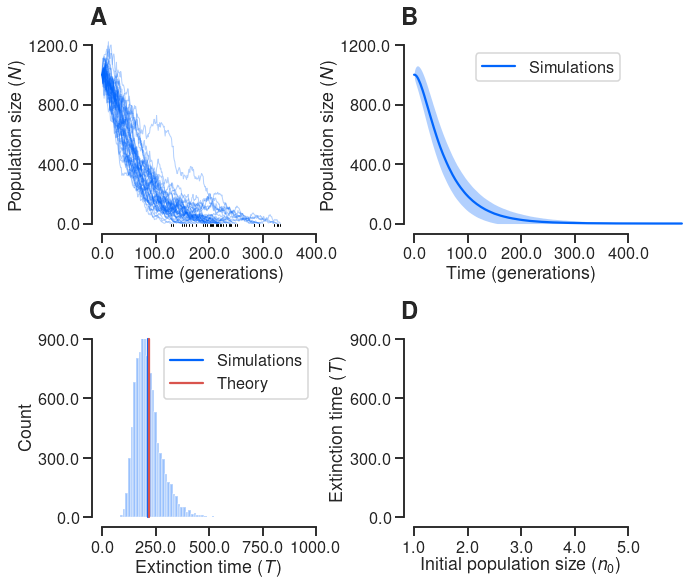

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8.5, 8))

red = sns.xkcd_rgb["pale red"]
blu = sns.xkcd_rgb["bright blue"]

fig.subplots_adjust()

set_up_axes(ax1, xmin=0, xmax=400, xstep=100, ymin=0, ymax=1200, ystep=400, rnd=1, 
    ylabel=r'Population size $(N)$', xlabel='Time (generations)', part_label=r'\textbf{A}')
set_up_axes(ax2, xmin=0, xmax=400, xstep=100, ymin=0, ymax=1200, ystep=400, rnd=1, 
    ylabel=r'Population size $(N)$', xlabel='Time (generations)', part_label=r'\textbf{B}')
set_up_axes(ax3, xmin=0, xmax=1000, xstep=250, ymin=0, ymax=900, ystep=300, rnd=1, 
    ylabel='Count', xlabel='Extinction time $(T)$', part_label=r'\textbf{C}')
set_up_axes(ax4, xmin=1, xmax=5.01, xstep=1, ymin=0, ymax=900, ystep=300, rnd=1, 
    ylabel=r'Extinction time $(T)$', xlabel=r'Initial population size $(n_0)$', part_label=r'\textbf{D}')

ax1.set_position([.121, .62, .35, .31])
ax2.set_position([.631, .62, .35, .31])
ax3.set_position([.121, .11, .35, .31])
ax4.set_position([.631, .11, .35, .31])

for i in range(1720, 1760):
    ax1.plot(nn[i], color=blu, alpha=.3, lw=1, clip_on=False)
    ax1.plot([tt[i]] * 2, [-6, -17], 'k-', clip_on=False, lw=1)

lo = m-s
lo[lo<0] = 0
ax2.fill_between(t, m+s, lo, color=blu, alpha=.3, clip_on=False, lw=0)
ax2.plot(t, m, clip_on=False, label='Simulations', color=blu)
# ax2.plot(t, nexp, '--', color=red, clip_on=False, label='Theory', dashes=[4, 2.9])
ax2.legend()

sns.distplot(tt, kde=False, ax=ax3, color=blu)
ax3.plot([tt.mean()] * 2, [0, 900], color=blu, clip_on=False, label='Simulations')
ax3.plot([Texp] * 2, [0, 900], color=red, clip_on=False, label='Theory')
ax3.legend()

# ax4.plot(fig2theory['logN'], fig2theory['T'], color=red)
# ax4.plot(fig2sim['logN'], fig2sim['T'], color=blu)
# ax4.fill_between(fig2sim['logN'], fig2sim['T'] + fig2sim['Tstd'], fig2sim['T'] - fig2sim['Tstd'], 
#     color=blu, alpha=.3, lw=0, clip_on=False)
# ax4.set_xticklabels(['$10$', '$10^{2}$', '$10^{3}$', '$10^{4}$', '$10^{5}$'])

plt.savefig('../figures/fig2.pdf')

## Figure S1

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

red = sns.xkcd_rgb["pale red"]
blu = sns.xkcd_rgb["bright blue"]

fig.subplots_adjust()

set_up_axes(ax, xmin=1, xmax=5.01, xstep=1, ymin=0, ymax=1.6, ystep=.4, rnd=1, 
    xlabel=r'Initial population size $(n_0)$', ylabel=r'CV$[T]$', 
    part_label='')

ax.set_position([.18, .2, .79, .75])

ax.plot(fig2sim['logN'], fig2sim['Tstd'] / fig2sim['T'], 'o', ms=6,
    color=blu, label='Simulations', clip_on=False)
ax.plot(fig2theory['logN'], fig2theory['Tstd'] / fig2theory['T'], color=red, 
    label='Theory', clip_on=False)
ax.legend()

ax.set_xticklabels(['10', '$10^{2}$', '$10^{3}$', '$10^{4}$', '$10^{5}$'])

plt.savefig('../figures/figS1.pdf')

In [31]:
tt.max()

684